In [1]:
# Access astronomical databases
from pyvo import registry  # version >=1.6

# Moc and HEALPix tools
from mocpy import MOC

# Coordinates manipulation
from astropy.coordinates import SkyCoord

# Sky visualization
from ipyaladin import Aladin  # version >=0.4.0

# For plots
import matplotlib.pyplot as plt

import pandas as pd

# Welcome to VizieR example workflow

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

**Notes:** 

It is a generic notebook, highlighting what can be done once you chose a catalog. This workflow is suggested by [CDS](https://cdsweb.unistra.fr/) (Strasbourg Astronomical Data Center, house of [VizieR](https://vizier.cds.unistra.fr/viz-bin/VizieR)).

The notebook exploits [pyVO](https://pyvo.readthedocs.io/en/latest/), an advanced library  of The [Virtual Observatory](https://ivoa.net/).

[Astroquery](https://astroquery.readthedocs.io/en/latest/vizier/vizier.html) (not used here) is a well-documented, user-friendly alternative.

--------------------------------------------------------

## 1. Setup

This example notebook has the following dependencies: 

**Required**
- pyvo : this library facilitates the access to the Virtual Observatory (VO) resources. VizieR is part of the VO.
This notebook needs version >=1.4.1
**Optional, for visualization**
- ipyaladin : this is the Aladin-lite sky viewer, bundled as a jupyter widget. It allows to plot catalogs and multi-order coverages (MOC)
- matplotlib : an other option to see catalog points and MOCs

## 2. Metadata exploration with the Virtual Observatory registry

This part uses [pyvo](https://pyvo.readthedocs.io/en) to connect to the VO registry.

In [2]:
# the catalogue name in VizieR
CATALOGUE = "J/A+A/587/A65"

We first retrieve the catalogue information.

In [3]:
# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

In [4]:
# We can print metadata information about the catalogue
#voresource.describe(verbose=True)
voresource.describe(verbose=True)

Visible and near-infrared solar spectra
Short Name: J/A+A/587/A65
IVOA Identifier: ivo://cds.vizier/j/a+a/587/a65
Access modes: tap#aux, web
- tap#aux: https://tapvizier.cds.unistra.fr/TAPVizieR/tap
- webpage: https://vizier.cds.unistra.fr/viz-bin/VizieR-2?-source=J/A+A/587/A65

We present a new solar flux atlas with the aim of understanding wavelength
precision and accuracy in solar benchmark data. The atlas covers the
wavelength range 405-2300nm and was observed at the Institut fur Astrophysik,
Gottingen (IAG), with a Fourier transform spectrograph (FTS). In contrast to
other FTS atlases, the entire visible wavelength range was observed
simultaneously using only one spectrograph setting. We compare the wavelength
solution of the new atlas to the Kitt Peak solar flux atlases and to the HARPS
frequency-comb calibrated solar atlas. Comparison reveals systematics in the
two Kitt Peak FTS atlases resulting from their wavelength scale construction,
and shows consistency between the IAG and

We can also inspect in details the `resource` object and access the attributes not provided by the describe method. See for example, the first author of a resource: 

In [5]:
voresource.creators[0]

'Reiners A.'

## 3. Access the tabular data of this catalog

We can have a look at the tables available in the catalogue.

In [6]:
tables = voresource.get_tables()
print(f"In this catalogue, we have {len(tables)} tables.")
for table_name, table in tables.items():
    print(f"{table_name}: {table.description}")

In this catalogue, we have 3 tables.
J/A+A/587/A65/tablea1: Absolute convective blueshift of FeI lines measured from the IAG atlas
J/A+A/587/A65/spnir: NIR atlas 1000-2300nm
J/A+A/587/A65/spvis: VIS atlas 405-1065nm


In [7]:
# We can also extract the tables names for later use
tables_names = list(tables.keys())
tables_names

['J/A+A/587/A65/tablea1', 'J/A+A/587/A65/spnir', 'J/A+A/587/A65/spvis']

The actual data can then be accessed using any of the ``access_modes`` of the voresource.

In [8]:
voresource.access_modes()

{'tap#aux', 'web'}

The web access is found by following the ``reference_url``

In [9]:
voresource.reference_url

'https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/587/A65'

### 3.1 Execute a SQL/ADQL query

The ``tap#aux`` in the ``access_mode`` response indicates that we can also do a SQL/ADQL query for these VizieR tables.

On the first table of the catalogue, we execute an <a href='https://www.ivoa.net/documents/latest/ADQL.html'>ADQL</a> query.

In [10]:
first_table_name = tables_names[1]

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = tap_service.search(
    f'select TOP 1000 * from "{first_table_name}"',
)
tap_records

<DALResultsTable length=1000>
recno      Wave         nFlux         rFlux    
          cm**-1                               
int32    float64       float64       float64   
----- ------------- -------------- ------------
    1 4347.82178977 0.922568929035 0.0155350892
    2 4347.82367304 0.930302628703 0.0156656709
    3 4347.82555631 0.934483666362 0.0157364327
    4 4347.82743958 0.938258038314 0.0158003494
    5 4347.82932285 0.944661328678 0.0159085412
    6 4347.83120612 0.950471936424 0.0160067566
    7 4347.83308939 0.951535092961 0.0160250235
    8 4347.83497265 0.949353488479 0.0159886442
    9 4347.83685592 0.951478010568  0.016024787
  ...           ...            ...          ...
  992 4349.68810899 0.987556110582 0.0170028731
  993 4349.68999226  0.99279038873 0.0170933716
  994 4349.69187553 0.991628027627 0.0170737375
  995  4349.6937588 0.985577885943 0.0169699434
  996 4349.69564207 0.980955941227 0.0168907363
  997 4349.69752534 0.980956348943 0.0168911181
  998  434

In [11]:
# get the first table of the catalogue
first_table_name = tables_names[0]

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = tap_service.search(
    f'select TOP 1000 * from "{first_table_name}"',
)
tap_records

<DALResultsTable length=1000>
recno  lambda    EW   relDepth  ConvBS
         nm    0.1 pm           m / s 
int32 float64  int16  float64  float64
----- -------- ------ -------- -------
    1 405.1819     --      0.6  -548.7
    2  405.305     79     0.69   -44.4
    3  405.344     60     0.62  -625.3
    4 405.5322     50     0.52  -472.2
    5 405.6181     80     0.74  -597.1
    6 405.7491     --     0.43  -401.4
    7  405.849     46     0.72  -127.7
    8 405.9363    101     0.75  -672.1
    9   405.99     74     0.74  -168.6
  ...      ...    ...      ...     ...
  992 588.1116     12     0.11  -201.4
  993 588.1657     15     0.12  -818.6
  994  588.291     16     0.14  -549.5
  995 588.3381      6     0.05  1552.7
  996 588.9097      6     0.06    55.9
  997 589.2808     17     0.25 -1237.1
  998 589.3511      4     0.08 -1066.6
  999 589.4327     18      0.2   226.2
 1000 589.4868      7     0.05  -755.9

In [12]:
first_table_name = tables_names[0]
tap_service = voresource.get_service("tap")
tap_records = tap_service.search(
    f'select TOP 10000000 * from "{first_table_name}"',
)
tap_records

<DALResultsTable length=1251>
recno  lambda    EW   relDepth  ConvBS
         nm    0.1 pm           m / s 
int32 float64  int16  float64  float64
----- -------- ------ -------- -------
    1 405.1819     --      0.6  -548.7
    2  405.305     79     0.69   -44.4
    3  405.344     60     0.62  -625.3
    4 405.5322     50     0.52  -472.2
    5 405.6181     80     0.74  -597.1
    6 405.7491     --     0.43  -401.4
    7  405.849     46     0.72  -127.7
    8 405.9363    101     0.75  -672.1
    9   405.99     74     0.74  -168.6
  ...      ...    ...      ...     ...
 1243 741.3196    140     0.56  -159.9
 1244 742.0711     49     0.35  -405.0
 1245 742.3603     20     0.13  -407.0
 1246 744.2961     --     0.36  -416.2
 1247 744.5072     38     0.26  -478.5
 1248 744.7802    178     0.59  -223.2
 1249 744.9445     38     0.23  -413.0
 1250  745.605     11     0.09  -416.1
 1251 746.3575     26     0.21  -414.5

In [13]:
vals = pd.read_csv("./results.csv")
vals

,Wave,Area
0,4348.944218,0.091235
1,4351.049712,0.064459
2,4356.219285,0.009132
3,4356.226818,0.009060
4,4357.514973,0.003247
...,...,...
1760,4999.491119,0.000000
1761,4999.498652,0.000000
1762,4999.506185,0.000000
1763,4999.521251,0.000000


In [14]:
vals = vals[vals["Area"] != 0.0]
vals

,Wave,Area
0,4348.944218,0.091235
1,4351.049712,0.064459
2,4356.219285,0.009132
3,4356.226818,0.009060
4,4357.514973,0.003247
...,...,...
1308,4986.521048,0.003697
1368,4988.195274,0.003508
1475,4990.671772,0.003281
1690,4996.624784,0.003455


In [15]:
def convert_wavenumber_to_wavelength(df, wavename='Wave', areaname='Area'):
    """
    Convierte número de onda en cm⁻¹ a longitud de onda en nm y transforma el área
    
    Parámetros:
    -----------
    df : DataFrame
        DataFrame con columnas de número de onda y área
    wavename : str
        Nombre de la columna de número de onda (cm⁻¹)
    areaname : str
        Nombre de la columna de área
    
    Retorna:
    --------
    DataFrame con las nuevas columnas
    """
    # Crear copia para no modificar el original
    df_transformed = df.copy()
    
    # 1. Convertir de cm⁻¹ a nm
    df_transformed['Wavelength_nm'] = 1e7 / df_transformed[wavename]
    
    # 2. Transformar el área usando el jacobiano
    # d(ν)/d(λ) = -1/λ², pero en valor absoluto y considerando unidades
    # Área en espacio λ = Área en espacio ν × |dν/dλ| = Área_ν × (ν² / 10⁷)
    df_transformed[f'{areaname}_transformed'] = (
        df_transformed[areaname] * (df_transformed[wavename]**2) / 1e4
    )
    
    # También podemos calcularlo usando λ
    # df_transformed[f'{areaname}_transformed'] = (
    #     df_transformed[areaname] * (1e7 / df_transformed['Wavelength_nm']**2)
    # )
    
    return df_transformed

# Aplicar la transformación
vals_transformed = convert_wavenumber_to_wavelength(vals)

In [16]:
wavelengths = vals_transformed["Wavelength_nm"]
areas = vals_transformed["Area_transformed"]
vals_transformed

,Wave,Area,Wavelength_nm,Area_transformed
0,4348.944218,0.091235,2299.408661,172.555473
1,4351.049712,0.064459,2298.295966,122.032050
2,4356.219285,0.009132,2295.568553,17.328553
3,4356.226818,0.009060,2295.564583,17.193514
4,4357.514973,0.003247,2294.885975,6.166328
...,...,...,...,...
1308,4986.521048,0.003697,2005.406155,9.192728
1368,4988.195274,0.003508,2004.733065,8.729481
1475,4990.671772,0.003281,2003.738265,8.171181
1690,4996.624784,0.003455,2001.350998,8.626057


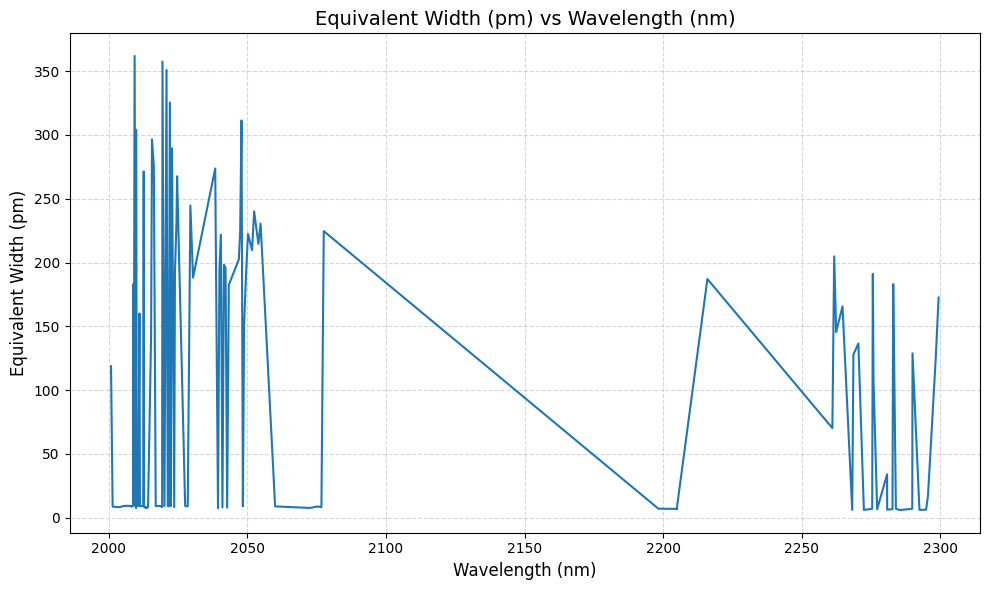

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, areas)

# Etiquetas y título
plt.xlabel('Wavelength (nm)', fontsize=12)
plt.ylabel('Equivalent Width (pm)', fontsize=12)
plt.title('Equivalent Width (pm) vs Wavelength (nm)', fontsize=14)

# Cuadrícula y ajustes visuales
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("Area.png")

In [22]:
vals_transformed.round(3).to_csv('results_transformed.csv', index=False)


In [19]:
tables_names

['J/A+A/587/A65/tablea1', 'J/A+A/587/A65/spnir', 'J/A+A/587/A65/spvis']